In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=3

import tensorflow as tf
import numpy as np
import h5py as h5

import matplotlib.pyplot as plt
import random
import glob

tf.__version__

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=3


'2.1.0-dev20191106'

In [2]:
# open an h5 file to get the astronomical and rfi visibilities
hfiles = list(glob.glob('/data/*.h5'))
h5_fp = np.random.choice(hfiles)

with h5.File(h5_fp, 'r') as fp:
    v_ast = fp['output/vis_clean'][()]
    v_rfi = fp['output/vis_dirty'][()]

v_ast.shape, v_rfi.shape

((800, 15, 4096, 4), (800, 15, 4096, 4))

In [3]:
# create a noise term to add to the above
mu = 0
sigma=.17
real_part = np.random.normal(mu,sigma, v_ast.shape)
im_part = np.random.normal(mu,sigma, v_ast.shape)
noise = real_part + 1j*im_part

In [4]:
# create the final simulated set of visibilities
alpha = .1
v_obs = v_ast + alpha*v_rfi + noise

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]


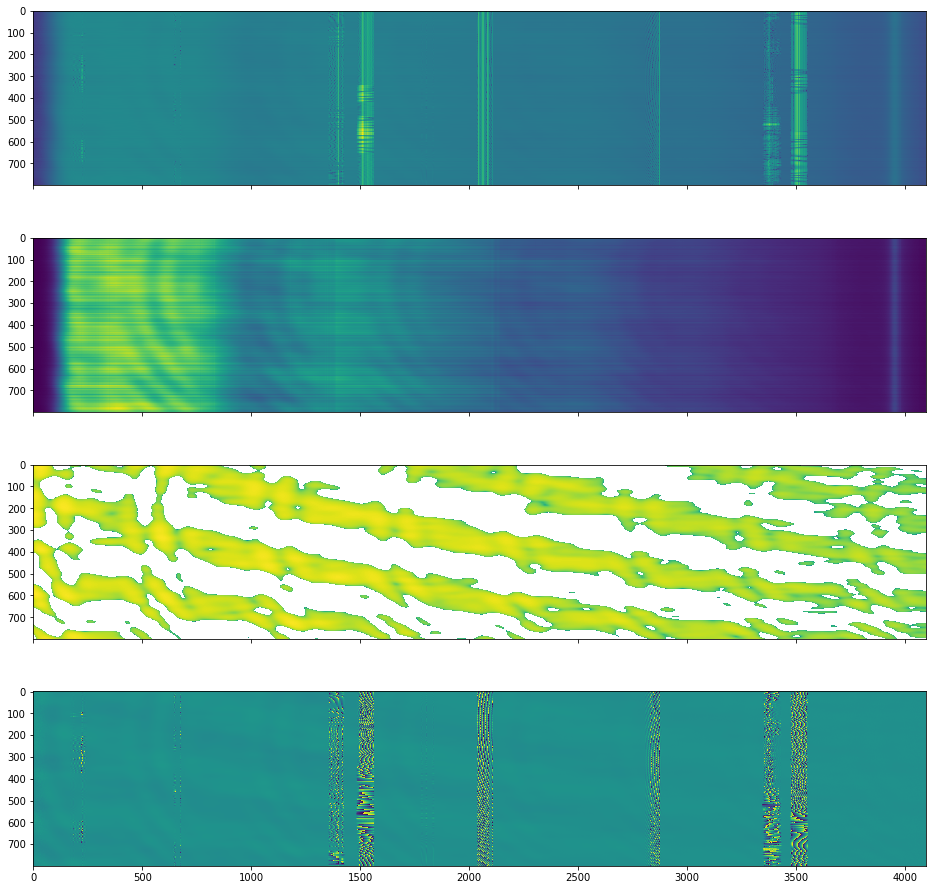

In [5]:
# check that everything seems plausible by generating a few plots
fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(4, 1, sharex=True, figsize=(16., 16))
#fig = plt.figure(figsize=(4., 16.))

#pcm = ax1.pcolor(X, Y, Z,
#                   norm=colors.LogNorm(vmin=Z.min(), vmax=Z.max()),
#                   cmap='PuBu_r')

#fig.colorbar(ax=ax1, extend='max')

ax1.imshow(np.log(np.abs(v_obs[:,0,:,0])))
ax2.imshow(np.abs(v_ast[:,0,:,0]))
ax3.imshow(np.log(np.angle(v_ast[:,0,:,0]))) #np.log(np.abs(v_rfi[:,0,:,0]+ noise[:,0,:,0])))
ax4.imshow(np.angle(v_obs[:,0,:,0]))


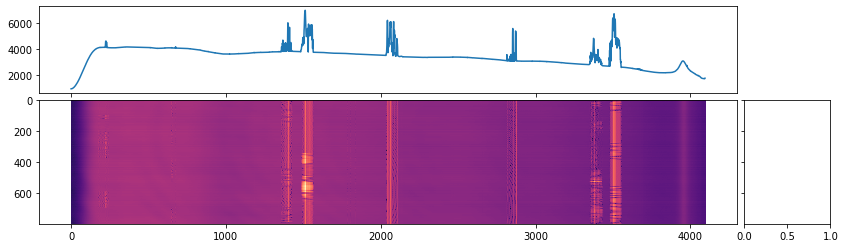

In [6]:
# plot both the collapsed x and y axis of the observed visibilities

from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(16., 4.))
wat = np.log(np.abs(v_obs[:,0,:,0]))
x = wat.sum(0)
y = wat.sum(1)
ax.imshow(wat, cmap='magma')

# create new axes on the right and on the top of the current axes
# The first argument of the new_vertical(new_horizontal) method is
# the height (width) of the axes to be created in inches.
divider = make_axes_locatable(ax)
axHistx = divider.append_axes("top", 1.2, pad=0.1, sharex=ax)
axHisty = divider.append_axes("right", 1.2, pad=0.1, sharey=ax)

# make some labels invisible
axHistx.xaxis.set_tick_params(labelbottom=False)
axHisty.yaxis.set_tick_params(labelleft=False)

# now determine nice limits by hand:
binwidth = 0.25
xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
lim = (int(xymax/binwidth) + 1)*binwidth

bins = np.arange(-lim, lim + binwidth, binwidth)
axHistx.plot(x)
#axHisty.plot(y)

#axHistx.hist(x, bins=bins)
#axHisty.hist(y, bins=bins, orientation='horizontal')


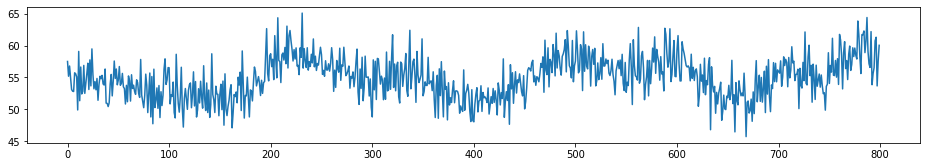

In [7]:
# plot the time-varying behaviour from a random channel during the observation
fig = plt.figure(figsize=(16., 2.5))
plt.plot(np.abs(v_obs[:,0,np.random.randint(v_obs.shape[2]),0]))
plt.show()

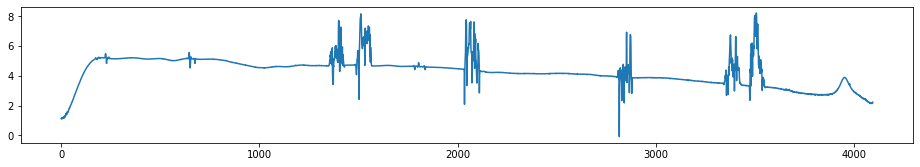

In [8]:
# plot the spectrum from a random time during the observation
fig = plt.figure(figsize=(16., 2.5))
plt.plot(np.log(np.abs(v_obs[np.random.randint(v_obs.shape[0]),0,:,0])))
plt.show()

In [9]:
# tensorflow dataset
dataset_obs = tf.data.Dataset.from_tensors(v_obs)

In [10]:
v_obs_rearranged=np.swapaxes(v_obs, 0, 2)
v_obs_rearranged=np.swapaxes(v_obs_rearranged, 1, 2)
v_obs_rearranged.shape, dataset_obs

((4096, 800, 15, 4),
 <TensorDataset shapes: (800, 15, 4096, 4), types: tf.complex128>)

In [18]:
import keras
from keras.layers import Conv3D
from keras.layers import MaxPooling3D
from keras.layers import BatchNormalization

model = keras.models.Sequential()
model.add(Conv3D(4, kernel_size=(2,2,2), strides=1, padding='same', input_shape = ((4096,800,16,4)), data_format = 'channels_last'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling3D(pool_size=(2,2,2), padding='same'))

model.add(Conv3D(4, kernel_size=(2,2,2), strides=1, padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling3D(pool_size=(2,2,2), padding='same'))

model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 4096, 800, 16, 4)  132       
_________________________________________________________________
batch_normalization_9 (Batch (None, 4096, 800, 16, 4)  16        
_________________________________________________________________
max_pooling3d_23 (MaxPooling (None, 2048, 400, 8, 4)   0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 2048, 400, 8, 4)   132       
_________________________________________________________________
batch_normalization_10 (Batc (None, 2048, 400, 8, 4)   16        
_________________________________________________________________
max_pooling3d_24 (MaxPooling (None, 1024, 200, 4, 4)   0         
Total params: 296
Trainable params: 280
Non-trainable params: 16
______________________________________________________

In [5]:
import complexnn

import keras
from keras import models
from keras import layers
from keras import optimizers

In [31]:
model = keras.models.Sequential()

model.add(complexnn.conv.ComplexConv3D(32, kernel_size=(3,3,3), strides=1, padding='same', input_shape = ((4096,800,16,4)), data_format = 'channels_last'))
#model.add(complexnn.bn.ComplexBatchNormalization())
#model.add(complexnn.norm.ComplexLayerNorm())
model.add(layers.MaxPooling3D((2, 2, 2), padding='same'))

model.add(complexnn.conv.ComplexConv3D(32, kernel_size=(3,3,3), strides=1, padding='same'))
model.add(layers.MaxPooling3D((2, 2, 2), padding='same'))

model.add(complexnn.conv.ComplexConv3D(32, kernel_size=(3,3,3), strides=1, padding='same'))
model.add(layers.MaxPooling3D((2, 2, 2), padding='same'))

model.add(complexnn.conv.ComplexConv3D(32, kernel_size=(3,3,3), strides=1, padding='same'))
model.add(layers.MaxPooling3D((2, 2, 2), padding='same'))

model.add(complexnn.conv.ComplexConv3D(32, kernel_size=(3,3,3), strides=1, padding='same'))
model.add(layers.MaxPooling3D((2, 2, 1), padding='same'))

model.add(complexnn.conv.ComplexConv3D(32, kernel_size=(3,3,3), strides=1, padding='same'))
model.add(layers.MaxPooling3D((2, 2, 1), padding='same'))

model.add(complexnn.conv.ComplexConv3D(32, kernel_size=(3,3,3), strides=1, padding='same'))
model.add(layers.MaxPooling3D((2, 2, 1), padding='same'))

model.add(complexnn.conv.ComplexConv3D(32, kernel_size=(3,3,3), strides=1, padding='same'))
model.add(layers.MaxPooling3D((2, 2, 1), padding='same'))

model.add(complexnn.conv.ComplexConv3D(32, kernel_size=(3,3,3), strides=1, padding='same'))
model.add(layers.MaxPooling3D((2, 2, 1), padding='same'))

model.add(complexnn.conv.ComplexConv3D(32, kernel_size=(3,3,3), strides=1, padding='same'))
model.add(layers.MaxPooling3D((2, 2, 1), padding='same'))

model.summary()

#model.compile(optimizer=optimizers.Adam(), loss='mse')

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
complex_conv3d_57 (ComplexCo (None, 4096, 800, 16, 64) 3520      
_________________________________________________________________
max_pooling3d_64 (MaxPooling (None, 2048, 400, 8, 64)  0         
_________________________________________________________________
complex_conv3d_58 (ComplexCo (None, 2048, 400, 8, 64)  55360     
_________________________________________________________________
max_pooling3d_65 (MaxPooling (None, 1024, 200, 4, 64)  0         
_________________________________________________________________
complex_conv3d_59 (ComplexCo (None, 1024, 200, 4, 64)  55360     
_________________________________________________________________
max_pooling3d_66 (MaxPooling (None, 512, 100, 2, 64)   0         
_________________________________________________________________
complex_conv3d_60 (ComplexCo (None, 512, 100, 2, 64) 

In [19]:
np.abs(v_obs[:,0,:,0]).shape

(800, 4096)

In [18]:
savetxt('data.csv', np.abs(v_obs[:,0,:,0]), delimiter=',')